In [326]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb

from scipy.stats import norm, multivariate_normal
import pandas as pd

from plot_utilities import plot_gaussian_contour

### 1D example

In [37]:
clusters = list(range(2))
mu = [0, 1.5]
sigma = [1, 0.2]
w = [0.6, 0.3]

N = 30
x = []
label = []
for i in range(N):
    lab = np.random.choice(clusters)
    label.append(lab)
    x.append(norm.rvs(loc=mu[lab], scale=sigma[lab]))

In [38]:
df = pd.DataFrame({
    'label': label,
    'x': x
})

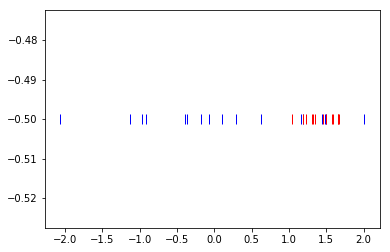

In [39]:
plt.plot(df[df['label']==0]['x'], [-0.5]*sum(df['label']==0),'|', color='b', ms=10)
plt.plot(df[df['label']==1]['x'], [-0.5]*sum(df['label']==1),'|', color='r', ms=10)


In [260]:
values, vector = np.linalg.eig([[1,1], [0.4, 1]])

In [262]:
np.eye(2)

array([[1., 0.],
       [0., 1.]])

In [379]:
class GmmEm:
    def __init__(self, x):
        self.x = np.array(x)
        self.N, self.d = self.x.shape
        self.K = None
        self.weights = None
        self.means = None
        self.covs = None
    
    def initialize(self, K):
        self.K = K
        m0 = np.mean(x, axis=0)
        cov0 = np.cov(x.T)

        self.weights = [1.0/K] * K
        self.means = multivariate_normal.rvs(mean=m0, cov=cov0, size=K)
        cov_values, _ = np.linalg.eig(cov0)
        self.covs = np.array([np.eye(self.d) * 0.1 *cov_values.max()
                             for _ in range(K)])
        
    def e_step(self):
        r = []
        for k in range(K):
            r.append(self.weights[k] * 
                     multivariate_normal.pdf(self.x, 
                                             mean=self.means[k],
                                             cov=self.covs[k]))
        r = np.array(r).T
        r_sum = np.einsum('ik->i', r)
        r = np.einsum('ik,i->ik', r, 1.0/r_sum)
        return r
    
    def m_step(self, r):
        weights_new = 1.0/N * np.einsum('ik->k', r)
        means_new = 1.0/N * \
                    np.einsum('k, ik,id->kd', 
                              1.0/weights_new, 
                              r, 
                              self.x)
        deviations = np.array([self.x - means_new[k] for k in range(self.K)])
        covs_new = 1.0/N * \
                    np.einsum('k,ik,kid,kiD->kdD', 
                              1.0/weights_new, 
                              r, 
                              deviations, 
                              deviations)
        
        self.weights = weights_new
        self.means = means_new
        self.covs = covs_new
        
    def print_params(self):
        print('GMM clustering')
        for k in range(self.K):
            print('cluster ' + str(k) + ':')
            print('   weigth:     ' + str(self.weights[k]))
            print('   mean:       ' + str(list(self.means[k])))
            print('   covariance: ' + str([list(self.covs[k, d, :]) for d in range(self.d)]))

In [356]:
def plot2D_gmm_data(ax, gmm, color='k'):
    x_plot = gmm.x[:,0]
    y_plot = gmm.x[:,1]

    ax.scatter(x_plot, y_plot, c=color, marker='.', s=50)
    wx = x_plot.max() - x_plot.min()
    wy = y_plot.max() - y_plot.min()
    margin = 0.3
    ax.set_xlim([x_plot.min() - wx*margin, x_plot.max() + wx*margin])
    ax.set_ylim([y_plot.min() - wy*margin, y_plot.max() + wy*margin])

In [246]:
def plot2D_gmm(ax, gmm):
    assert gmm.d == 2
    x_plot = gmm.x[:,0]
    y_plot = gmm.x[:,1]
    ax.plot(x_plot, y_plot, 'k.')
    wx = x_plot.max() - x_plot.min()
    wy = y_plot.max() - y_plot.min()
    margin = 0.3
    ax.set_xlim([x_plot.min() - wx*margin, x_plot.max() + wx*margin])
    ax.set_ylim([y_plot.min() - wy*margin, y_plot.max() + wy*margin])

    for k in range(gmm.K):
        plot_gaussian_contour(ax, gmm.means[k,:], gmm.covs[k,:,:], color='k')
    return ax

In [385]:
def plot2D_gmm_2K(ax, gmm, colors=('red', 'blue')):
    assert gmm.d == 2
    assert gmm.K == 2
    x_plot = gmm.x[:,0]
    y_plot = gmm.x[:,1]
    
    c0 = np.array(to_rgb(colors[0]))
    c1 = np.array(to_rgb(colors[1]))
    
    r = gmm.e_step()
    point_colors= []
    for i in range(r.shape[0]):
        point_colors.append(c0 * r[i,0] + c1 * r[i,1])
    
    ax.scatter(x_plot, y_plot, c=point_colors, marker='.', s=50)
    wx = x_plot.max() - x_plot.min()
    wy = y_plot.max() - y_plot.min()
    margin = 0.3
    ax.set_xlim([x_plot.min() - wx*margin, x_plot.max() + wx*margin])
    ax.set_ylim([y_plot.min() - wy*margin, y_plot.max() + wy*margin])

    for k, c in zip(range(gmm.K), colors):
        plot_gaussian_contour(ax, gmm.means[k,:], gmm.covs[k,:,:], color=c)
    return ax

In [347]:
N = 100
clusters = list(range(2))
means_true = [
    [0, 0], 
    [4, 4]
]
covs_true = [
    [
        [1, 0],
        [0, 1]
    ],
    [
        [1, 0],
        [0, 1]
    ],
]
weights_true = [0.5, 0.5]

labels_true = []
x = []
for _ in range(N):
    lab = np.random.choice(clusters)
    labels_true.append(lab)
    xi = multivariate_normal.rvs(mean=means_true[lab], cov=covs_true[lab])
    x.append(xi)
x = np.array(x)

In [382]:
gmm = GmmEm(x)

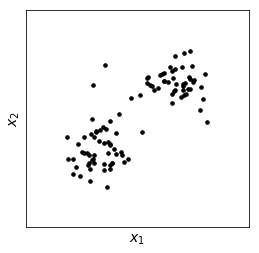

In [383]:
plt.figure(figsize=(4,4))
ax = plt.gca()
plot2D_gmm_data(ax, gmm)
ax.set_yticks([])
ax.set_xticks([])
ax.set_xlabel('$x_1$', fontsize=14)
ax.set_ylabel('$x_2$', fontsize=14)
plt.savefig('./05-gmm-data.pdf', bbox_inches='tight')
plt.show()

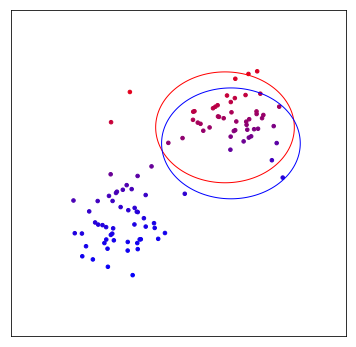

In [391]:
K = 2
gmm.initialize(K)

plt.figure(figsize=(6,6))
ax = plt.gca()
plot2D_gmm_2K(ax, gmm)
ax.set_yticks([])
ax.set_xticks([])
plt.savefig('./05-gmm-initial.pdf', bbox_inches='tight')
plt.show()

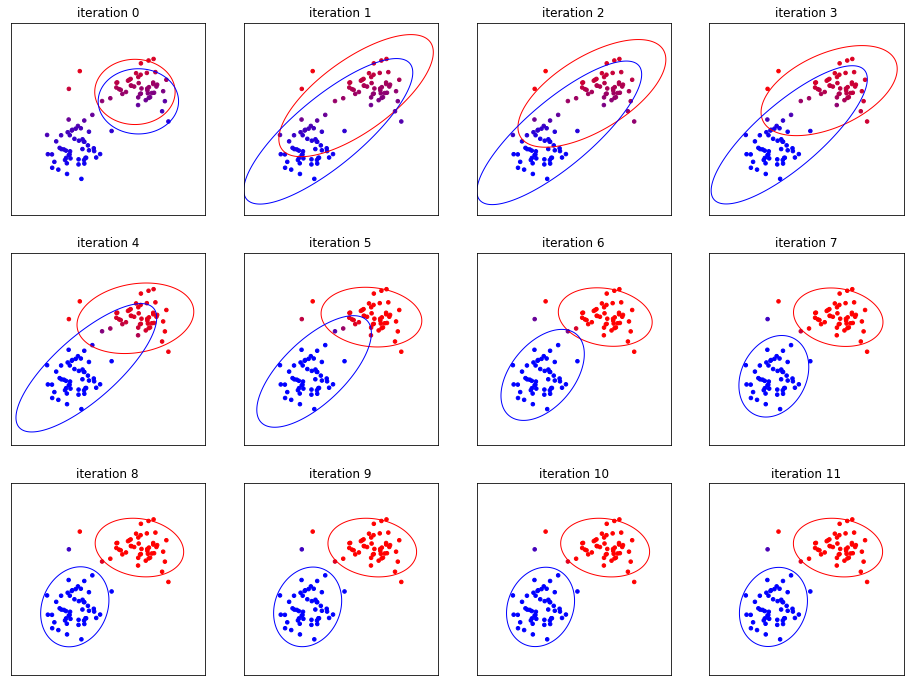

In [392]:
fig, ax_rows = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(16, 12))
axes = ax_rows.flatten()
for idx, ax in enumerate(axes):
    plot2D_gmm_2K(ax, gmm)
    ax.set_title('iteration ' + str(idx))
    r = gmm.e_step()
    ax.set_yticks([])
    ax.set_xticks([])
    gmm.m_step(r)
plt.savefig('./05-gmm-iterations.pdf', bbox_inches='tight')
plt.show()

In [393]:
gmm.print_params()

GMM clustering
cluster 0:
   weigth:     0.48160249385149007
   mean:       [4.091231961200195, 4.370867175867641]
   covariance: [[1.2756134510318413, -0.14353201485256883], [-0.1435320148525689, 0.8324663234248318]]
cluster 1:
   weigth:     0.5183975061485099
   mean:       [0.10434683090071124, -0.15111751180421165]
   covariance: [[0.7370722120553913, 0.16655042572678366], [0.16655042572678366, 1.506947720261967]]


In [49]:
a = np.linspace(0, 11, 12).reshape([4,3])
a

array([[ 0.,  1.,  2.],
       [ 3.,  4.,  5.],
       [ 6.,  7.,  8.],
       [ 9., 10., 11.]])

In [50]:
np.mean(a, axis=0)

array([4.5, 5.5, 6.5])

In [55]:
np.cov(a.T)

array([[15., 15., 15.],
       [15., 15., 15.],
       [15., 15., 15.]])

In [57]:
b = [1,2,3]
np.repeat(b, 3).reshape()

array([1, 1, 1, 2, 2, 2, 3, 3, 3])

In [61]:
a - np.array([1, 2, 3])

array([[-1., -1., -1.],
       [ 2.,  2.,  2.],
       [ 5.,  5.,  5.],
       [ 8.,  8.,  8.]])

TypeError: ufunc 'sqrt' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

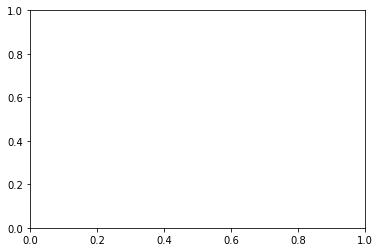

In [308]:
plt.scatter([1,1], [0, 1], 'k.')

In [316]:
colors.to_rgba('blue')

(0.0, 0.0, 1.0, 1.0)

In [319]:
np.array(colors.to_rgba((1.0, 0.0, 0.0, 1.0))) + np.array(colors.to_rgba('blue'))

array([1., 0., 1., 2.])

In [366]:
str(a)

'[[ 0.  1.  2.]\n [ 3.  4.  5.]\n [ 6.  7.  8.]\n [ 9. 10. 11.]]'

In [371]:
a.__str__().

'[[ 0.  1.  2.]\n [ 3.  4.  5.]\n [ 6.  7.  8.]\n [ 9. 10. 11.]]'

In [ ]:
[[ 0.  1.  2.]
 [ 3.  4.  5.]
 [ 6.  7.  8.]
 [ 9. 10. 11.]]